# Project 3: Representation Learning

## K-Means

### Data Loader
We will use 2-dimensional data in this section. Specifically, the dataset are
2D points $[(x_1, x_2), (x_2, y_2), \dots, (x_n, y_n)]$ that form 5 distinct clusters.

In [ ]:
# install seaborn for better visualization
!pip install seaborn

Prepare and plot the training set.

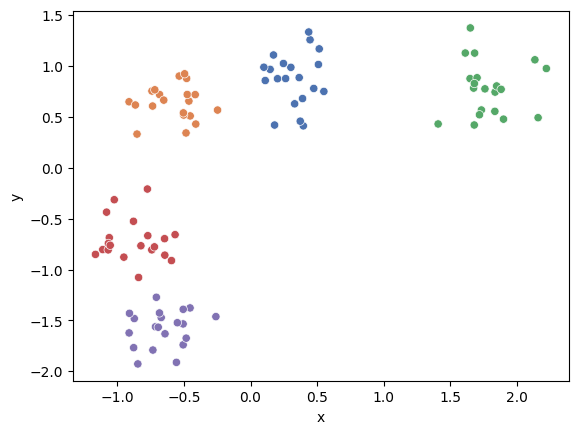

In [ ]:
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

num_samples = 100
num_centers = 5

X_train, true_labels = make_blobs(
    n_samples=num_samples,
    centers=num_centers,
    random_state=80,
)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(
    x=[X[0] for X in X_train],
    y=[X[1] for X in X_train],
    hue=true_labels,
    palette="deep",
    legend=None,
)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

### K-Means Implementation
Now we are implementing the algorithm.

First, we define "similarity" between points. For our dataset, we will be using Euclidean distances.

In [ ]:
import numpy as np


def euclidean_dist(cur_point, dataset):
    '''
    cur_point has dimensions (m,), dataset has dimensions (n, m), and output will be of size (n,).
    '''
    dists = None
    # Your Code Starts Here
    if len(dataset) > 0:
        dists = []
    for i in range(len(dataset)):
        dist = np.sqrt(((cur_point[0]-dataset[i][0])**2)+((cur_point[1]-dataset[i][1])**2))
        dists.append(dist)
    # End of Your Code

    return dists

Now, we implement the actual K-Means. We initialize K-Means with two parameters: number of clusters, and max number of iteractions, which you will use in the init function. Then, we implement the fit function and a predict function to assign each data point to the centroids.

In [ ]:
import random
from numpy.random import uniform


class KMeans:
    def __init__(self, n_clusters=5, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None

    def fit(self, X_train):
        """
        # Step 1:
        Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        then the rest are initialized w/ probabilities proportional to their distances to the first
        Pick a random point from train data for first centroid
        """
        # Your Code Starts Here
        np.random.seed(42)
        init = np.random.randint(0, len(X_train))
        self.centroids = [X_train[init]]
        dists = euclidean_dist(X_train[init], X_train)
        probs = dists/sum(dists)
        for i in range(1, self.n_clusters):
            next = np.random.choice(len(X_train), p=probs)
            self.centroids.append(X_train[next])
        # End of Your Code

        """
        Step 2:
        Iterate, adjusting centroids until converged (new centroids are the same as previous centroids)
        or until passed max_iter
        """
        iteration = 0
        prev_centroids = None

        # Your Code Starts Here
        prev_centroids = []
        for _ in range(self.max_iter):
            prev_centroids.append(self.centroids)
            # initialize dictionary with each current centroid index
            assignments = {}
            for i in range(self.n_clusters):
                assignments[i] = []
            # assign each data point to a centroid
            for i in range(len(X_train)):
                dists = euclidean_dist(X_train[i], self.centroids)
                closest_idx = dists.index(min(dists))
                assignments[closest_idx].append(X_train[i])
            # calculate mean of each centroid and reassign centroids
            self.centroids = []
            for _, points in assignments.items():
                x = 0
                y = 0
                for point in points:
                    x += point[0]
                    y += point[1]
                avg = [x/len(points), y/len(points)]
                dists = euclidean_dist(avg, points)
                new_centroid_idx = dists.index(min(dists))
                self.centroids.append(points[new_centroid_idx])
            # checks for convergence by seeing if previous centroids are the same as new
            converged = True
            for i in range(self.n_clusters):
                dist = (prev_centroids[-1][i][0]-self.centroids[i][0]) + (prev_centroids[-1][i][1]-self.centroids[i][1])
                if dist != 0:
                    converged = False
            if converged:
                break

        # End of Your Code

    def predict(self,X):
        """
        Assign each data point to the nearest centroid.

        return:
            centroids: a list of the final centroids.
            centroid_idxs: a list of the indices of the centroids that each data point is assigned to.
        """
        centroids = []
        centroid_idxs = []

        # Your Code Starts Here
        centroids = self.centroids
        for i in range(len(X)):
            dists = euclidean_dist(X[i], self.centroids)
            centroid_idxs.append(dists.index(min(dists)))
        # End of Your Code

        return centroids, centroid_idxs

Finally, we test and visualize our k-means algorithm. In the code below, we separate the different true labels by color (as previously), and we distinguish predicted labels by marker styles.

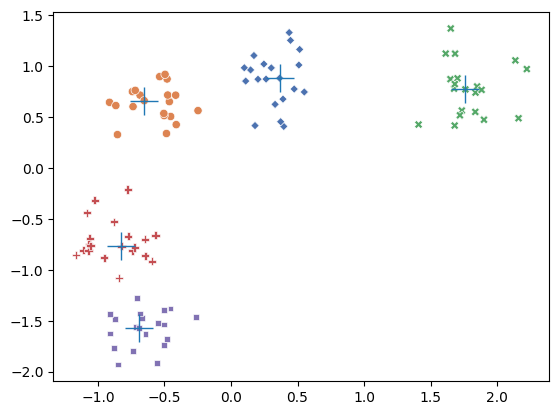

In [ ]:
# Run k-means
model = KMeans(n_clusters=num_centers)
model.fit(X_train)

# View results
class_centers, classification = model.predict(X_train)

# plot the ground truths
sns.scatterplot(
    x=[X[0] for X in X_train],
    y=[X[1] for X in X_train],
    hue=true_labels,
    style=classification,
    palette="deep",
    legend=None
)
# plot the centroids
plt.plot(
    [x for x, _ in class_centers],
    [y for _, y in class_centers],
    '+',
    markersize=20,
)
plt.show()

## Principal Component Analysis 

In this problem we apply PCA for dimensionality reduction to the MNIST dataset.

### Load the dataset and visualize some examples

In [ ]:
# Download dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

print('Loading and preprocessing data')
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home='data')
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

Loading and preprocessing data


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


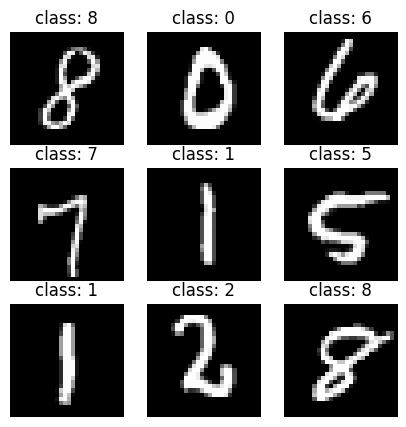

In [ ]:
# plot some random samples from training set
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'class: {y_train[i]}')
    ax.axis('off')

### A simple linear classifier

In [ ]:
class LinearClassifier:
    """
    Simple linear classifier trained using full-batch gradient descent.
    - Maps n_features -> n_classes logits using a weight matrix W and bias vector b.
    - Applies softmax to the logits to get class probabilities that sum to 1.
    - In prediction, we take the class with the highest probability as our output class.
    """
    def __init__(self, n_features, classes=np.arange(10), eps=1e-4):
        self.classes = classes
        self.W = np.random.rand(n_features, len(classes)) / 30
        self.b = np.random.rand(len(classes)) / 30
        self.eps = eps

    def fit(self, X, y):
        assert len(X) == len(y)
        assert set(y) == set(self.classes)

        for i in range(200):
            # forward pass
            z = X @ self.W + self.b

            # softmax to convert logits to class probabilities
            exp_z = np.exp(z)
            softmax = exp_z / exp_z.sum(axis=1, keepdims=True)

            # cross-entropy loss
            n = len(X)
            loss = -np.log(softmax[range(n), y]).sum() / n

            # backward pass
            dL_dz = softmax
            dL_dz[range(n), y] -= 1
            dL_dz /= n

            dL_dW = X.T @ dL_dz
            dL_db = dL_dz.sum(axis=0)

            # update weights
            self.W -= self.eps * dL_dW
            self.b -= self.eps * dL_db

            # print classification accuracy
            if i % 50 == 0:
                predictions = np.argmax(z, axis=1)
                accuracy = (predictions == y).mean()
                print(f'iteration {i}: loss {loss:.4f}, accuracy {accuracy:.4f}')
        predictions = np.argmax(z, axis=1)
        accuracy = (predictions == y).mean()
        print(f'Final iteration {i}: loss {loss:.4f}, accuracy {accuracy:.4f}')

    def predict(self, X):
        z = X @ self.W + self.b
        return np.argmax(z, axis=1)


### Baseline

We see the baseline accuracy of a simple linear classifier trained with full-batch gradient descent.

In [ ]:
# subsample every 30 pixels
X_train_subset = X_train[:, ::30]
print(f'Using {X_train_subset.shape[1]} features')

classifier = LinearClassifier(n_features=X_train_subset.shape[1])

# center the data and store the means
feat_means = X_train_subset.mean(axis=0, keepdims=True)
X_train_subset = X_train_subset - feat_means
classifier.fit(X_train_subset, y_train)

Using 27 features
iteration 0: loss 5.7334, accuracy 0.0811
iteration 50: loss 1.5099, accuracy 0.5270
iteration 100: loss 1.3820, accuracy 0.5575
iteration 150: loss 1.3500, accuracy 0.5657
Final iteration 199: loss 1.3365, accuracy 0.5712


In [ ]:
# evaluate our test accuracy
X_test_subset = X_test[:, ::30]
preds = classifier.predict(X_test_subset - feat_means)
test_acc = (preds == y_test).mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.5736


### PCA for dimensionality reduction in classification

We will now try to find a better set of features. We implement the fit function and predict funtion which projects our data onto the principal components we choose to keep from our truncated SVD.


In [ ]:
class PCA:
    def __init__(self, n_components):
        # number of principal components to keep when we apply PCA
        assert n_components <= 784
        self.n_components = n_components

        self.feature_means = None
        self.U, self.S, self.Vt = None, None, None
        self.U_subset, self.S_subset, self.Vt_subset = None, None, None

    def fit(self, X):
        """
        Steps:
        - Center the data (compute, store, and subtract the mean of each feature)
        - Take the SVD of the centered data
        - Truncate the SVD by keeping only the first n_components (singular values)
        """
        n_samples, n_features = X.shape

        self.feature_means = np.mean(X, axis=0)
        X = X - self.feature_means
        # take SVD
        self.U, self.S, self.Vt = np.linalg.svd(X)
        # store truncated SVD
        self.U_subset = self.U[:, :self.n_components]
        self.S_subset = np.diag(self.S)[:self.n_components, :self.n_components]
        self.Vt_subset = self.Vt[:self.n_components, :]

    def predict(self, X):
        """
        Steps:
        - Center the data (subtract the mean of each feature, stored in the fit)
        - Project the centered data onto the principal components

        Returns:
        - Projected data of shape (X.shape[0], n_components)
        """
        if self.feature_means is None:
            raise ValueError('fit the PCA model first')

        X = X - self.feature_means
        # project the centered data set onto our kept principal components
        predicted = np.dot(X, self.Vt_subset.T)
        return predicted
        ## End of Your Code ##



In [ ]:
# fit PCA
pca = PCA(27)
pca.fit(X_train)

Explained variance ratio with 27 components: 0.3143


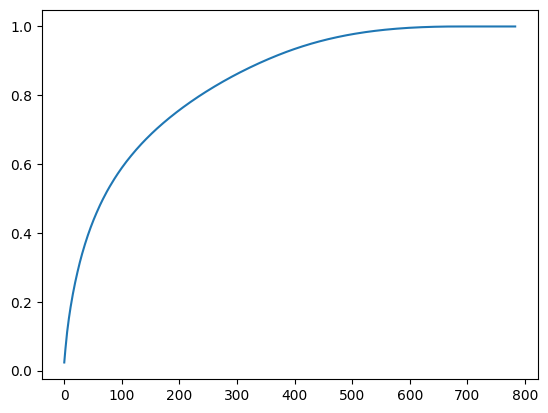

In [ ]:
# plot the explained variance ratio
S = pca.S
plt.plot(S.cumsum() / S.sum())

# report the truncated feature ratio
explained_var_ratio = (S.cumsum() / S.sum())[pca.n_components]
print(f'Explained variance ratio with {pca.n_components} components: {explained_var_ratio:.4f}')

In [ ]:
X_train_subset = pca.predict(X_train)
X_test_subset = pca.predict(X_test)

classifier = LinearClassifier(n_features=27)
classifier.fit(X_train_subset, y_train)

iteration 0: loss 22.6984, accuracy 0.0844
iteration 50: loss 0.7038, accuracy 0.8604
iteration 100: loss 0.4988, accuracy 0.8744
iteration 150: loss 0.4329, accuracy 0.8786
Final iteration 199: loss 0.4166, accuracy 0.8798


In [ ]:
preds = classifier.predict(X_test_subset)
test_acc = (preds == y_test).mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.8782


### PCA for visualization

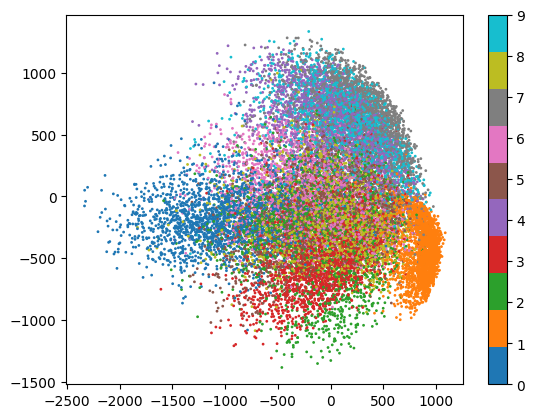

In [ ]:
# extract the first two PCs from the training set and plot it
X_train_subset = pca.predict(X_train)
X_train_subset = X_train_subset[:, :2]

plt.scatter(X_train_subset[:, 0], X_train_subset[:, 1], c=y_train, cmap='tab10', alpha=1.0, s=1)
plt.colorbar()

## Neural Network 

Now, we classify handwritten digits with neural networks from scratch. 

We implement the forward pass and backward pass of the linear layer. For the forward pass, it takes $x_l$ as input and outputs $x_{l+1}$.

$$x_{l+1} = w^\top x_{l} + b_{l}$$

For the backward pass, we compute backward gradients,

$$ \frac{\partial \ell(x, y)}{\partial w}=?$$
$$\frac{\partial \ell(x, y)}{\partial b}=?$$
$$\frac{\partial \ell(x, y)}{\partial x_{l}}=?$$

where $\ell$ is the loss function.

### Forward and Backward Propogation

In [ ]:
import numpy as np

class Layer(object):
    def __init__(self, shape, activ_func):
        "Implements a layer of a NN."

        self.w = np.random.uniform(-np.sqrt(2.0 / shape[0]),
                                   np.sqrt(2.0 / shape[0]),
                                   size=shape)
        self.b = np.zeros((1, shape[1]))

        # The activation function, for example, RELU, tanh, or sigmoid.
        self.activate = activ_func

        # The derivative of the activation function.
        self.d_activate = GRAD_DICT[activ_func]

    def forward(self, inputs):
        """Forward propagate the activation through the layer.

        Given the inputs (activation of previous layers),
        compute and save the activation of current layer,
        then return it as output.
        """

        scores = np.dot(inputs, self.w) + self.b

        # End of your code


        activations = self.activate(scores) 
        
        # Cache the inputs and the activations (to be used by backprop).

        self.inputs = inputs
        self.a = activations
        outputs = activations
        return outputs

    def backward(self, d_outputs):
        """Backward propagate the gradient through this layer.

        Given the gradient w.r.t the output of this layer
        (d_outputs), compute and save the gradient w.r.t the
        weights (d_w) and bias (d_b) of this layer and
        return the gradient w.r.t the inputs (d_inputs).
        """
    
        # d_scores:
        #     Derivatives of the loss w.r.t the scores (the result from linear transformation).
        #     A matrix of shape (N, H)
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        d_scores = d_outputs * self.d_activate(self.a) 

        # self.d_b:
        #     Derivatives of the loss w.r.t the bias, averaged over all data points.
        #     A matrix of shape (1, H)
        #     H is the number of hidden units in this layer.

        self.d_b = np.mean(d_scores) 

        # self.d_w:
        #     Derivatives of the loss w.r.t the weight matrix, averaged over all data points.
        #     A matrix of shape (H_-1, H)
        #     H_-1 is the number of hidden units in previous layer
        #     H is the number of hidden units in this layer.

        self.d_w = np.dot(self.inputs.T, d_scores) 

        # d_inputs:
        #     Derivatives of the loss w.r.t the previous layer's activations/outputs.
        #     A matrix of shape (N, H_-1)
        #     N is the number of data points.
        #     H_-1 is the number of hidden units in the previous layer.

        d_inputs = np.dot(d_scores, self.w.T) 

		# Compute the average value of the gradients, since
        # we are minimizing the average loss.
        self.d_b /= d_scores.shape[0]
        self.d_w /= d_scores.shape[0]

        return d_inputs

In [ ]:
import numpy as np

#########################
#  Multilayer Perceptron
#########################

class MLP(object):
    def __init__(self, input_dim, output_dim, sizes, activ_funcs):
        """Multilayer perceptron for multi-class classification.

        The object holds a list of layer objects, each one
        implements a layer in the network, the specification
        of each layer is decided by input_dim, output_dim,
        sizes and activ_funcs. Note that an output layer
        (linear) and loss function (softmax and
        cross-entropy) would be automatically added to the MLP.

        Input:
          input_dim: dimension of input.
          output_dim: dimension of output (number of labels).
          sizes: a list of integers specifying the number of
            hidden units on each layer.
          activ_funcs: a list of function objects specifying
            the activation function of each layer.

        """
        # Last layer is linear and loss is mean_cross_entropy_softmax
        self.sizes = [input_dim] + sizes[:] + [output_dim]
        self.activ_funcs = activ_funcs[:] + [linear]
        self.shapes = []
        for i in range(len(self.sizes)-1):
            self.shapes.append((self.sizes[i], self.sizes[i+1]))

        self.layers = []
        for i, shape in enumerate(self.shapes):
            self.layers.append(Layer(shape, self.activ_funcs[i]))

    def forwardprop(self, data, labels=None):
        """Forward propagate the activations through the network.

        Iteratively propagate the activations (starting from
        input data) through each layer, and output a
        probability distribution among labels (probs), and
        if labels are given, also compute the loss.
        """
        inputs = data
        for layer in self.layers:
            outputs = layer.forward(inputs)
            inputs = outputs

        probs = softmax(outputs)
        if labels is not None:
            return probs, self.loss(outputs, labels)
        else:
            return probs, None

    def backprop(self, labels):
        """Backward propagate the gradients/derivatives through the network.

        Iteratively propagate the gradients/derivatives (starting from
        outputs) through each layer, and save gradients/derivatives of
        each parameter (weights or bias) in the layer.
        """
        d_outputs = self.d_loss(self.layers[-1].a, labels)
        for layer in self.layers[::-1]:
            d_inputs = layer.backward(d_outputs)
            d_outputs = d_inputs

    def loss(self, outputs, labels):
        "Compute the cross entropy softmax loss."
        return mean_cross_entropy_softmax(outputs, labels)

    def d_loss(self, outputs, labels):
        "Compute derivatives of the cross entropy softmax loss w.r.t the outputs."
        return d_mean_cross_entropy_softmax(outputs, labels)

    def predict(self, data):
        "Predict the labels of the data."
        probs, _ = self.forwardprop(data)
        return np.argmax(probs, axis=1)


class GradientDescentOptimizer(object):
    def __init__(self, learning_rate, decay_steps=1000,
                 decay_rate=1.0):
        "Gradient descent with staircase exponential decay."
        self.learning_rate = learning_rate
        self.steps = 0.0
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def update(self, model):
        "Update model parameters."
        for layer in model.layers:
            layer.w -= layer.d_w * self.learning_rate
            layer.b -= layer.d_b * self.learning_rate
        self.steps += 1
        if (self.steps + 1) % self.decay_steps == 0:
            self.learning_rate *= self.decay_rate


# Utility functions.
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(a=None, x=None):
    if a is not None:
        return a * (1 - a)
    else:
        return d_sigmoid(a=sigmoid(x))

def relu(x):
    "The rectified linear activation function."
    return np.clip(x, 0.0, None)

def d_relu(a=None, x=None):
    "Compute the derivative of RELU given activation (a) or input (x)."
    if a is not None:
        d = np.zeros_like(a)
        d[np.where(a > 0.0)] = 1.0
        return d
    else:
        return d_relu(a=relu(x))

def tanh(x):
    "The tanh activation function."
    return np.tanh(x)

def d_tanh(a=None, x=None):
    "The derivative of the tanh function."
    if a is not None:
        return 1 - a ** 2
    else:
        return d_tanh(a=tanh(x))

def linear(x):
    return x

def d_linear(a=None, x=None):
    return 1.0

def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    f = np.exp(shifted_x)
    p = f / np.sum(f, axis=1, keepdims=True)
    return p

def mean_cross_entropy(outputs, labels):
    n = labels.shape[0]
    return - np.sum(labels * np.log(outputs)) / n

def mean_cross_entropy_softmax(logits, labels):
    return mean_cross_entropy(softmax(logits), labels)

def d_mean_cross_entropy_softmax(logits, labels):
    return softmax(logits) - labels


# Mapping from activation functions to its derivatives.
GRAD_DICT = {linear: d_linear, sigmoid: d_sigmoid, tanh: d_tanh, relu: d_relu}


We will preprocess the MNIST dataset by normalizing the pixel values to be between 0 and 1 and use one-hot encoding for the labels.

In [ ]:
# Download dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

print('Loading and preprocessing data')
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home='data')
X = X / 255.0
y = y.astype(int)

(train_data, test_data, train_labels, test_labels) = train_test_split(X, y, random_state=0, test_size=0.7)

def create_one_hot_labels(labels, dim=10):
    one_hot_labels = np.zeros((labels.shape[0], dim))
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

# Convert labels from integers to one-hot encodings
test_labels = create_one_hot_labels(test_labels)
train_labels = create_one_hot_labels(train_labels)

Loading and preprocessing data


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Training the Neural Network


In [ ]:
# Initialize model
print('Initializing neural network')
model = MLP(784, 10, [16], [sigmoid])

selected = np.random.randint(test_data.shape[0], size=100)
true_labels = np.argmax(test_labels[selected], axis=1)
preds_init = model.predict(test_data[selected])

Initializing neural network


In [ ]:
print('Start training')

n_train = train_data.shape[0]
n_epochs = 25
batch_size = 100
opt = GradientDescentOptimizer(0.01)

train_loss_list = []
train_accuracy_list = []
for i in range(n_epochs):
    sum_loss = 0.0
    for j in range((n_train - 1) // batch_size + 1):
        batch_data = train_data[j*batch_size:(j+1)*batch_size]
        batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
        _, loss = model.forwardprop(batch_data, batch_labels)
        if np.isnan(loss):
            print('batch %s loss is abnormal')
            print(loss)
            continue
        sum_loss += loss
        model.backprop(batch_labels)
        opt.update(model)
    train_loss = sum_loss/(j+1)
    train_accuracy = (np.sum(model.predict(train_data) ==
                              np.argmax(train_labels, axis=1)) /
                      np.float64(train_labels.shape[0]))
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    print('=' * 20 + ('Epoch %d' % i) + '=' * 20)
    print('Train loss %s accuracy %s' % (train_loss, train_accuracy))

# Compute test loss and accuracy.
_, test_loss = model.forwardprop(test_data, test_labels)
test_accuracy = (np.sum(model.predict(test_data) ==
                        np.argmax(test_labels, axis=1)) /
                  np.float64(test_labels.shape[0]))
print('=' * 20 + 'Training finished' + '=' * 20 + '\n')
print ('Test loss %s accuracy %s\n' %
        (test_loss, test_accuracy))

preds_trained = model.predict(test_data[selected])

Start training
====================Epoch 0====================
Train loss 2.252970969436841 accuracy 0.24047619047619048
====================Epoch 1====================
Train loss 2.152591206440234 accuracy 0.5963809523809523
====================Epoch 2====================
Train loss 2.0606782431403543 accuracy 0.6200952380952381
====================Epoch 3====================
Train loss 1.965469854102801 accuracy 0.6358095238095238
====================Epoch 4====================
Train loss 1.8679210626386784 accuracy 0.6571428571428571
====================Epoch 5====================
Train loss 1.770159061920576 accuracy 0.6775238095238095
====================Epoch 6====================
Train loss 1.6741993351092836 accuracy 0.6979047619047619
====================Epoch 7====================
Train loss 1.5816579283664072 accuracy 0.7163809523809523
====================Epoch 8====================
Train loss 1.4937346610817908 accuracy 0.7325238095238096
====================Epoch 9=======

Plot the training loss and accuracy as a function of the number of epochs for debugging.

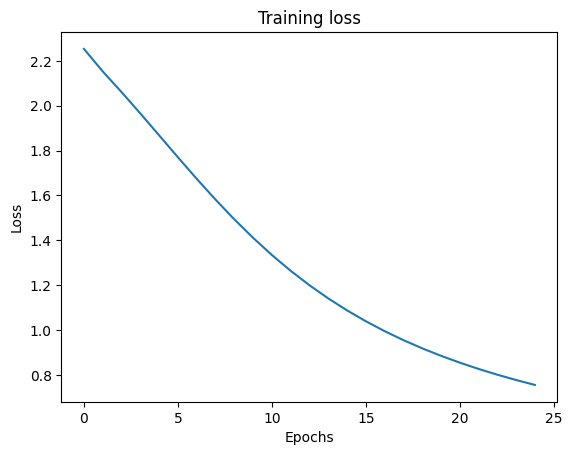

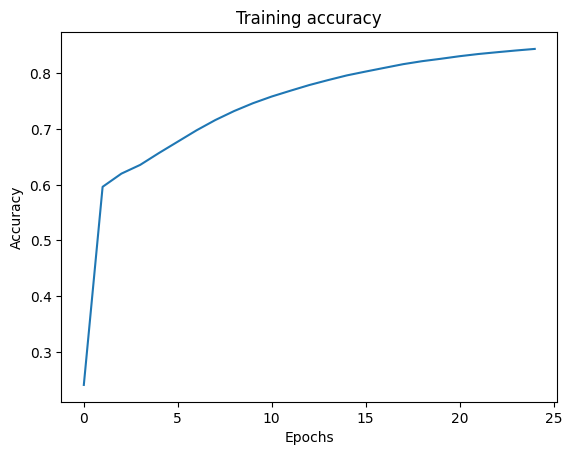

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy separately.
plt.plot(range(n_epochs), train_loss_list, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

plt.plot(range(n_epochs), train_accuracy_list, label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()

### Visualizing the Predictions

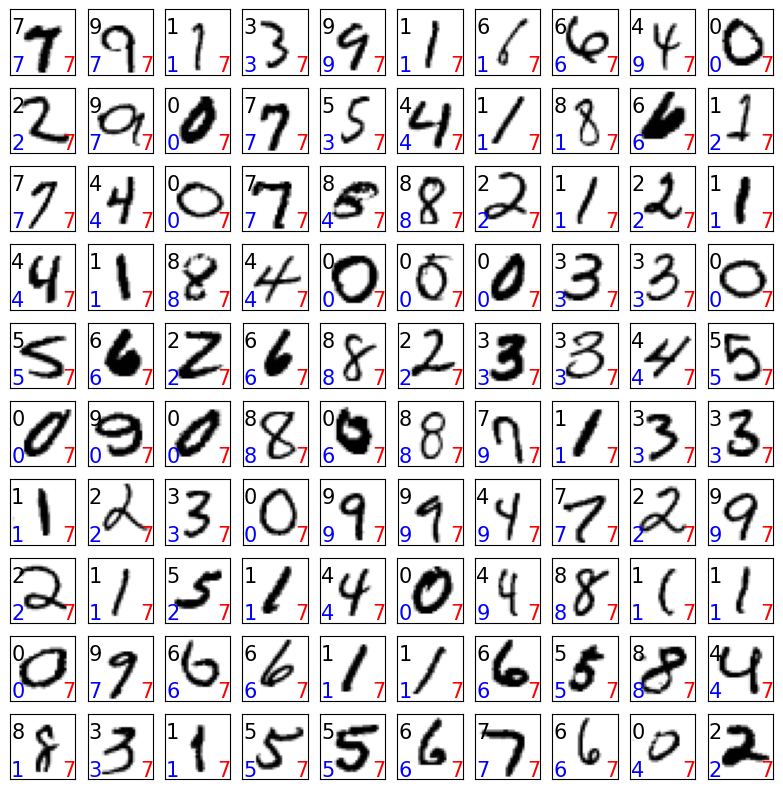

In [ ]:
import matplotlib.pyplot as plt

# plot sample test images together with their groundtruth
# and predicted labels before and after training

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for a, image, true_label, pred_init, pred_trained in zip(
        axes.flatten(), test_data[selected],
        true_labels, preds_init, preds_trained):
    a.imshow(image.reshape(28, 28), cmap='gray_r')
    a.text(0, 10, str(true_label), color="black", size=15)
    a.text(0, 26, str(pred_trained), color="blue", size=15)
    a.text(22, 26, str(pred_init), color="red", size=15)

    a.set_xticks(())
    a.set_yticks(())

plt.show()

Visualizing the Weights

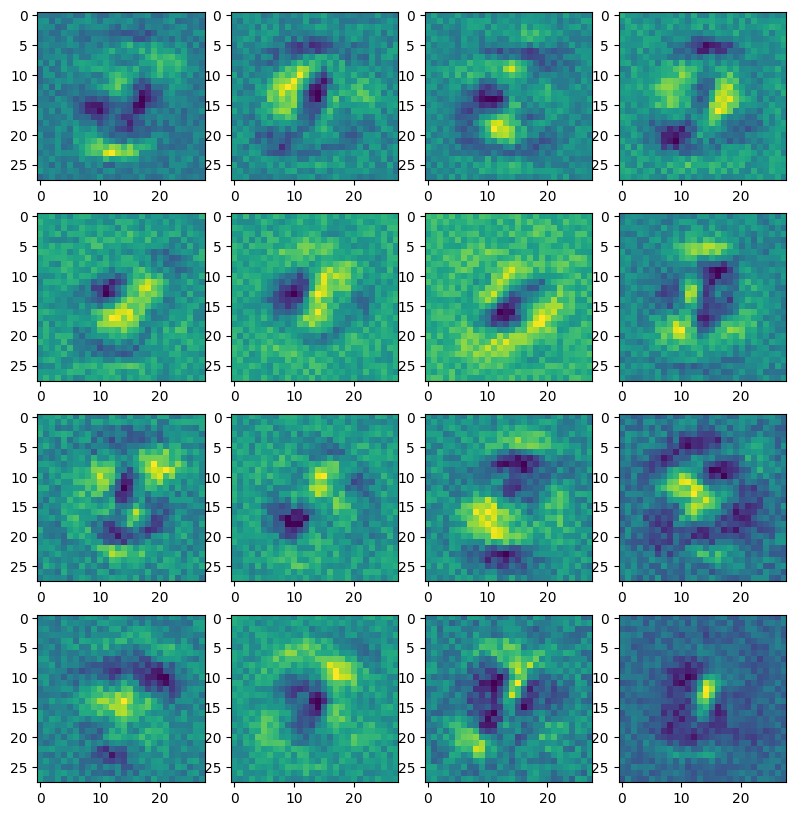

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
idx = 0
for a in axes.flatten():
    a.imshow(model.layers[0].w[:, idx].reshape((28, 28)))
    idx +=1
plt.show()

### Hyperparameter tuning

In [ ]:
# Initialize model
print('Initializing neural network')

model = MLP(784, 10, [16], [tanh])



################# Do not modify the following code ############
selected = np.random.randint(test_data.shape[0], size=100)
true_labels = np.argmax(test_labels[selected], axis=1)
preds_init = model.predict(test_data[selected])

print('Start training')

n_train = train_data.shape[0]
n_epochs = 25
batch_size = 100
opt = GradientDescentOptimizer(0.01)

for i in range(n_epochs):
    sum_loss = 0.0
    for j in range((n_train - 1) // batch_size + 1):
        batch_data = train_data[j*batch_size:(j+1)*batch_size]
        batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
        _, loss = model.forwardprop(batch_data, batch_labels)
        if np.isnan(loss):
            print('batch %s loss is abnormal')
            print(loss)
            continue
        sum_loss += loss
        model.backprop(batch_labels)
        opt.update(model)
    train_loss = sum_loss/(j+1)
    train_accuracy = (np.sum(model.predict(train_data) ==
                              np.argmax(train_labels, axis=1)) /
                      np.float64(train_labels.shape[0]))

    print('=' * 20 + ('Epoch %d' % i) + '=' * 20)
    print('Train loss %s accuracy %s' % (train_loss, train_accuracy))

# Compute test loss and accuracy.
_, test_loss = model.forwardprop(test_data, test_labels)
test_accuracy = (np.sum(model.predict(test_data) ==
                        np.argmax(test_labels, axis=1)) /
                  np.float64(test_labels.shape[0]))
print('=' * 20 + 'Training finished' + '=' * 20 + '\n')
print ('Test loss %s accuracy %s\n' %
        (test_loss, test_accuracy))

preds_trained = model.predict(test_data[selected])

Initializing neural network
Start training
====================Epoch 0====================
Train loss 1.7977321964007116 accuracy 0.7574761904761905
====================Epoch 1====================
Train loss 1.2644113574022473 accuracy 0.8031428571428572
====================Epoch 2====================
Train loss 0.9997318156038404 accuracy 0.8264761904761905
====================Epoch 3====================
Train loss 0.8394952625974006 accuracy 0.8408095238095238
====================Epoch 4====================
Train loss 0.7340659347933823 accuracy 0.8524761904761905
====================Epoch 5====================
Train loss 0.6599788707831059 accuracy 0.8605238095238095
====================Epoch 6====================
Train loss 0.6051014932987689 accuracy 0.867904761904762
====================Epoch 7====================
Train loss 0.5627474243156312 accuracy 0.8746190476190476
====================Epoch 8====================
Train loss 0.5289908775662444 accuracy 0.8788095238095238
====